# Project Final Report - Who contributes the most data?

Authors: Hunter, Sophia, Jiho, and Freya

## Introduction (write in Introduction.md first)

#### Background Information

...

#### The Question

...

#### The Data

...

## Methods & Results

#### Loading the Data

First, we must load in the nessary libaries for working with data frames, resizing graphs, working with predictive models, and using one-hot encoding respectivley.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(caret)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Then, we download the player data and read it into R.

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=18CyKdv1ppgp7RraugrDq66w_T-6dkrdG"

download.file(players_url, "players.csv")

players <- read_csv("players.csv")

glimpse(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…


#### Wrangling the Data

We will need to convert the columns to their proper types, so experience will be a factor, Age is an integer, ect. We also want to remove any rows with NA values, which in this case happens to only be in the Age column.

In [3]:
players <- mutate(players,
    experience = as_factor(experience),
    gender = as_factor(gender)) |>
    filter(!is.na(Age))


players <- players |> 
    select(Age, experience, 
           subscribe, played_hours)

glimpse(players)

Rows: 194
Columns: 4
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…
$ experience   <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateur, Regular…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…


Now we split the data into our training and testing sets. We will only use the training data for our visualizations and analysis.

In [4]:
set.seed(123)
players_split <- initial_split(players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

Next, we have to encode the data properly so that the model can interpret it. Both the experience and subscribe variables are currently in the wrong format. We will use one hot coding to fix the experience variable and a simple mutation to transform the subsribe variable.

In [5]:
players_train_encoded <- dummyVars("~ experience", data = players_train) |>
    predict(newdata = players_train) |>
    as.data.frame() |>
    bind_cols(players_train) |>
    select(-experience)

players_train_encoded <- mutate(players_train_encoded,
    subscribe_encoded = ifelse(subscribe == TRUE, 1, 0)) |>
    select(-subscribe)

players_test_encoded <- dummyVars("~ experience", data = players_test) |>
    predict(newdata = players_test) |>
    as.data.frame() |>
    bind_cols(players_test) |>
    select(-experience)

players_test_encoded <- mutate(players_test_encoded,
    subscribe_encoded = ifelse(subscribe == TRUE, 1, 0)) |>
    select(-subscribe)


glimpse(players_train_encoded)
glimpse(players_test_encoded)

Rows: 145
Columns: 8
$ experience.Pro      <dbl> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ experience.Veteran  <dbl> 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,…
$ experience.Amateur  <dbl> 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,…
$ experience.Regular  <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,…
$ experience.Beginner <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,…
$ Age                 <dbl> 19, 21, 17, 22, 17, 17, 17, 17, 17, 23, 18, 23, 17…
$ played_hours        <dbl> 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, …
$ subscribe_encoded   <dbl> 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,…
Rows: 49
Columns: 8
$ experience.Pro      <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ experience.Veteran  <dbl> 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,…
$ experience.Amateur  <dbl> 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,…
$ experience.Regular  <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,…

[description of methods]

In [6]:
experience_averages <- players_train |>
    group_by(experience) |>
    summarize(average_played_hours = mean(played_hours, na.rm = TRUE))

experience_averages

experience,average_played_hours
<fct>,<dbl>
Pro,0.4000000
Veteran,0.7805556
Amateur,4.7500000
Regular,18.8875000
Beginner,0.6037037


In order to understand how subscription status plays a role in played_hours we group the data into average played_hours according to subscription.

In [7]:
subscribe_averages <- players_train |>
    group_by(subscribe) |>
    summarize(mean_played_hours = mean(played_hours))

subscribe_averages

subscribe,mean_played_hours
<lgl>,<dbl>
FALSE,0.570000
TRUE,6.732381


Here we grouped the age data into different categories to better understand which age groups were more likey to have a larger played_hours value.

In [8]:
selected_hours_age <- players_train |>
    select(Age, played_hours) |>
    filter(!is.na(Age) & !is.na(played_hours))

mutated_hours_age = mutate(selected_hours_age,
    age_category = as_factor(ifelse(Age < 8, "<8",
                ifelse(Age >= 8 & Age <= 12, "8-12",
                ifelse(Age >= 13 & Age <= 17, "13-17",
                ifelse(Age >= 18 & Age <= 22, "18-22",
                ifelse(Age >= 23 & Age <= 27, "23-27",
                ifelse(Age >= 28 & Age <= 32, "28-32", "33+"))))))))

grouped_hours_age <- mutated_hours_age |>
    group_by(age_category) |>
    summarize(average_played_hours = mean(played_hours))

grouped_hours_age$age_category <- factor(grouped_hours_age$age_category, 
    levels = c("<8", "8-12", "13-17","18-22", "23-27", "28-32","33+"))


grouped_hours_age

age_category,average_played_hours
<fct>,<dbl>
18-22,6.476190
13-17,5.458824
23-27,3.333333
28-32,0.625000
33+,0.075000
8-12,1.233333


#### Summary of Dataset

Since we are concerned with experience, subscribe, age, and played_hours for our model, let's make some tables of summary statistics for the counts/measures of center of those variables.

In [9]:
summarize(players, 
    average_played_hours = mean(played_hours),
    median_played_hours = median(played_hours),
    average_age = mean(Age),
    median_age = median(Age))

summarize(group_by(players, experience), count = n())

summarize(group_by(players, subscribe), count = n())


average_played_hours,median_played_hours,average_age,median_age
<dbl>,<dbl>,<dbl>,<dbl>
5.904639,0.1,20.52062,19


experience,count
<fct>,<int>
Pro,13
Veteran,48
Amateur,63
Regular,35
Beginner,35


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,142


[additional summary]

#### Visualizations

For the first of our predictive variables, experience, we use a bar graph to show how it is related to played hours. Here we take the average played_hours of each experience cateogry and we see that the category "Regular" has a much higher average played_hours than the other categories.

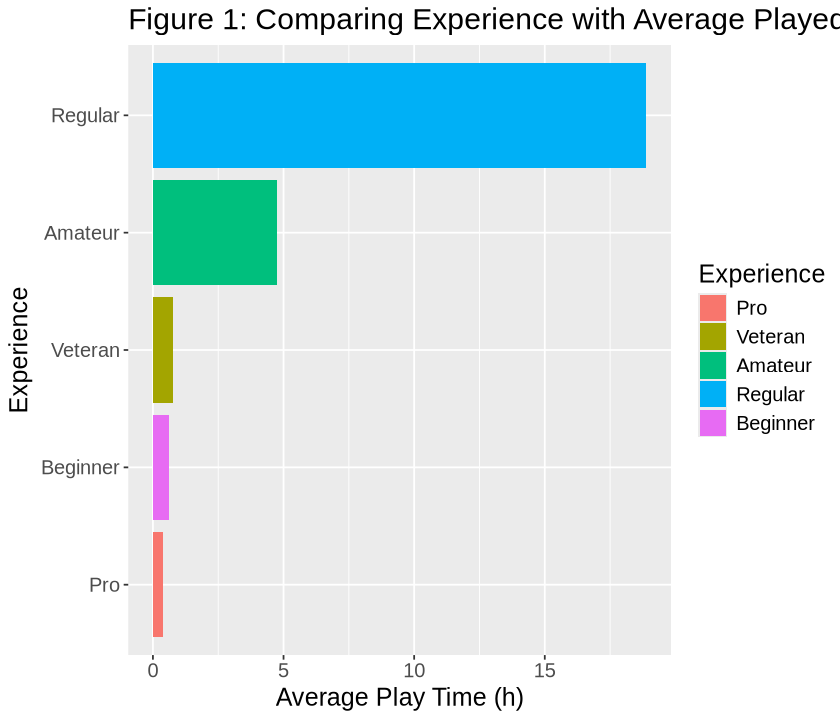

In [10]:
options(repr.plot.width = 7, repr.plot.height = 6)

experience_plot <- ggplot(experience_averages, 
                          aes(x = average_played_hours, y = fct_reorder(experience, average_played_hours),
                             fill = experience)) + 
    geom_bar(stat = "identity") + 
    labs(x = "Average Play Time (h)", y = "Experience", 
            title = "Figure 1: Comparing Experience with Average Played Hours",
            fill = "Experience") + 
    theme(text = element_text(size = 15))

experience_plot

Here, we observe the relationship between the subscribe variable and played hours by using a simliar aproach of average played_hours. Unsuprisingly, we find that people who have subscribed have a much higher average played_hours.

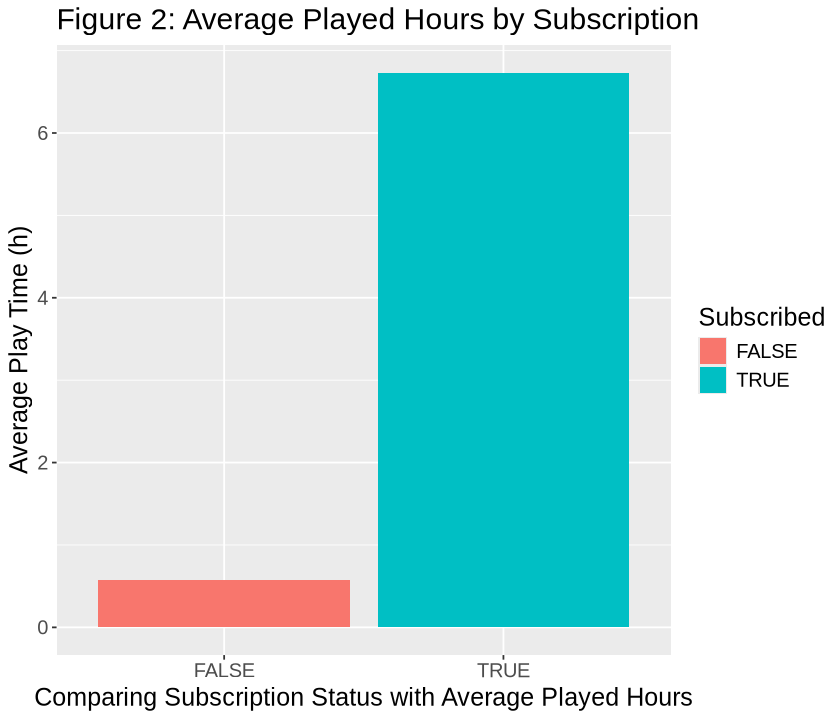

In [11]:
subscribe_plot <- ggplot(subscribe_averages, 
                          aes(x = subscribe, y = mean_played_hours, fill = subscribe)) +
    geom_bar(stat = "identity") +
    labs(x = "Comparing Subscription Status with Average Played Hours", y = "Average Play Time (h)", 
           title = "Figure 2: Average Played Hours by Subscription",
        fill = "Subscribed") +
    theme(text = element_text(size = 15))

subscribe_plot

Finnaly, we compare the age variable with average played_hours and seems to indicate people with ages between 13-22 have a much higher average hours_played.

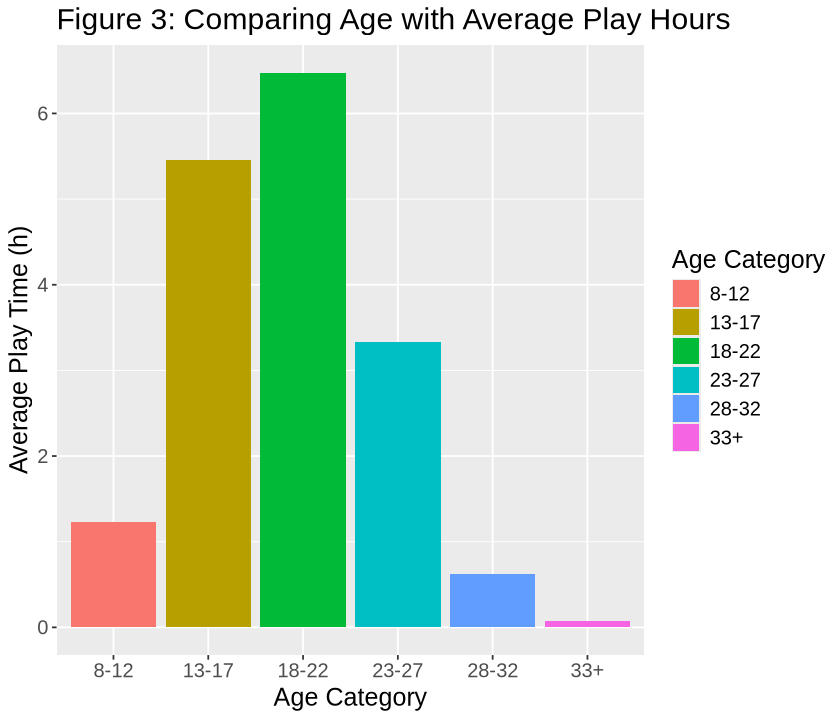

In [12]:
age_plot <- ggplot(grouped_hours_age, aes(x = age_category, y = average_played_hours, fill = age_category)) +
    geom_bar(stat = "identity") + 
    labs(x = "Age Category", y = "Average Play Time (h)",
         title = "Figure 3: Comparing Age with Average Play Hours", 
        fill = "Age Category") + 
    theme(text = element_text(size = 15))

age_plot

#### Modeling and Analysis

Now we will use a knn regression model to help predict the played_hours of a player given their age, experience, and subscription status. First we must use cross validation to find the best value of K that we will use for our model.

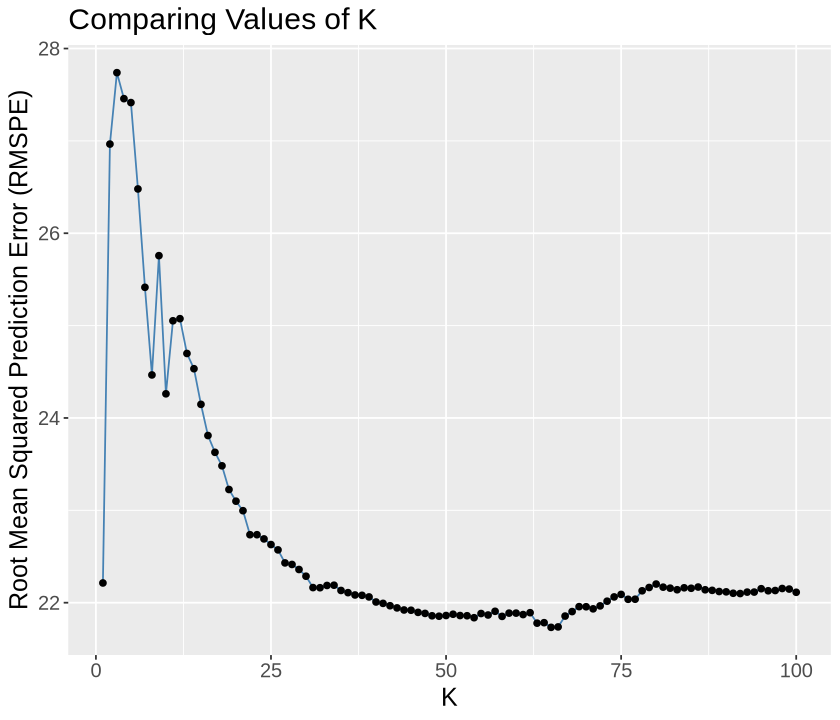

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train_encoded, v = 5, strata = played_hours)

knn_recipe <- recipe(played_hours ~ ., data = players_train_encoded) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

k_vals <- tibble(neighbors = 1:100)

knn_metrics <- workflow()|>
    add_recipe(knn_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    select(neighbors, mean)

metric_plot <- ggplot(knn_metrics, aes(x = neighbors, y = mean)) +
    geom_line(color = "steelblue") +
    geom_point() +
    labs(x = "K", y = "Root Mean Squared Prediction Error (RMSPE)", 
         title = "Comparing Values of K") +
    theme(text = element_text(size = 15))

metric_plot

Now looking at the graph above we can see that the ideal value of K is somewhere around K = 60. To find this precisely we can use slice_min to find the K with the smallest error.

In [17]:
lowest_rmspe <- slice_min(knn_metrics, mean, n = 1)
lowest_rmspe

neighbors,mean
<int>,<dbl>
65,21.73296


Ok, now that we know K = 65 is the best value for K we can create a model using that K and find its Root Mean Squared Percentage Error on the test data.

In [15]:
kmin <- lowest_rmspe |> pull(neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

players_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train_encoded)

test_predictions <- players_fit |>
  predict(players_test_encoded) |>
  bind_cols(players_test_encoded) 

test_predictions_summary <- test_predictions |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

test_predictions_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,32.56906


With an error rate of ~33 we can say that for a prediction we expect the actual played_hours to have an error of 33 hours

## Discussion (write in Discussion.md first)

#### Summary

...

#### Is this what you expected?

...

#### What is the impact of the findings?

...

#### Future Questions

...